In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares
import sys
import os

sys.path.append('..')
import irdetection.analysis.fitting.models as md
from irdetection.analysis.fitting.FitAPI import Fitter
from irdetection.analysis.fitting.models import Model
from irdetection.analysis.fitting.FitAPI_old import Fitter_old, Model_old
from irdetection.analysis.fitting.searcher import ResonancePeakSearcher
from irdetection.graphics.plots import plot_fit
from irdetection.graphics.colours import Palette
from irdetection.graphics.typography import Typography, Font
from irdetection.graphics.plots import plot
from irdetection.graphics.palettes import QSciencePalette, QScienceTypography

In [6]:
R_true = 2.317

def read_peaks_data_2(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    def process_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            bias_voltage = float(obj.attrs.get("bias_voltage"))
            bias_key = bias_voltage/R_true 
            if bias_key is not None:
                data_dict[bias_key] = obj[()]
                metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
            else:
                print(f"Warning: Dataset '{name}' missing 'bias_voltage' attribute.")

    with h5py.File(filename, 'r') as f:
        f.visititems(process_dataset)

    return data_dict, metadata_dict

# Estimate the initial guess of Qt
def peak_width(datax, datay):
    half_height_value = np.min(datay) + (np.max(datay) - np.min(datay)) / np.sqrt(2)
    hits = []
    above = datay[0] > half_height_value
    for i in range(1, len(datay)):
        new_above = datay[i] > half_height_value
        if new_above != above: 
            hits.append((datax[i] + datax[i-1]) / 2)
            above = new_above
    return abs(hits[-1] - hits[0])

{'f0': -25097.125518157558, 'phi': 0.20090186422755482, 'Qt': 17892.37077488239, 'Qc': 14336.104895288048, 'A': 12.340153040529819, 'B': 1.601982653318811e-07, 'C': 1.2567124506332096e-14, 'D': -7.403066804095434e-21, 'K': 19.69872461163149, 'fmin': 6234351171.0}
{'f0': -39589.348020217665, 'phi': 0.19249224668707887, 'Qt': 17863.556235504962, 'Qc': 14137.116747549626, 'A': 12.001210509115111, 'B': 1.545271356224947e-07, 'C': 1.1543842209095948e-14, 'D': -6.7374805020862246e-21, 'K': 20.041174830245094, 'fmin': 6234173694.0}
{'f0': -51974.705252971085, 'phi': 0.19123442819996322, 'Qt': 17993.222625929076, 'Qc': 14139.098342389734, 'A': 11.692003953277712, 'B': 1.5696176574947894e-07, 'C': 1.14768917971453e-14, 'D': -7.140002960317561e-21, 'K': 20.310055683504608, 'fmin': 6233583694.0}
{'f0': -48854.93087727362, 'phi': 0.18976140635628927, 'Qt': 18033.419443253373, 'Qc': 13973.005495269776, 'A': 11.486696646171087, 'B': 1.6399070115511082e-07, 'C': 1.321160875531216e-14, 'D': -7.9679582

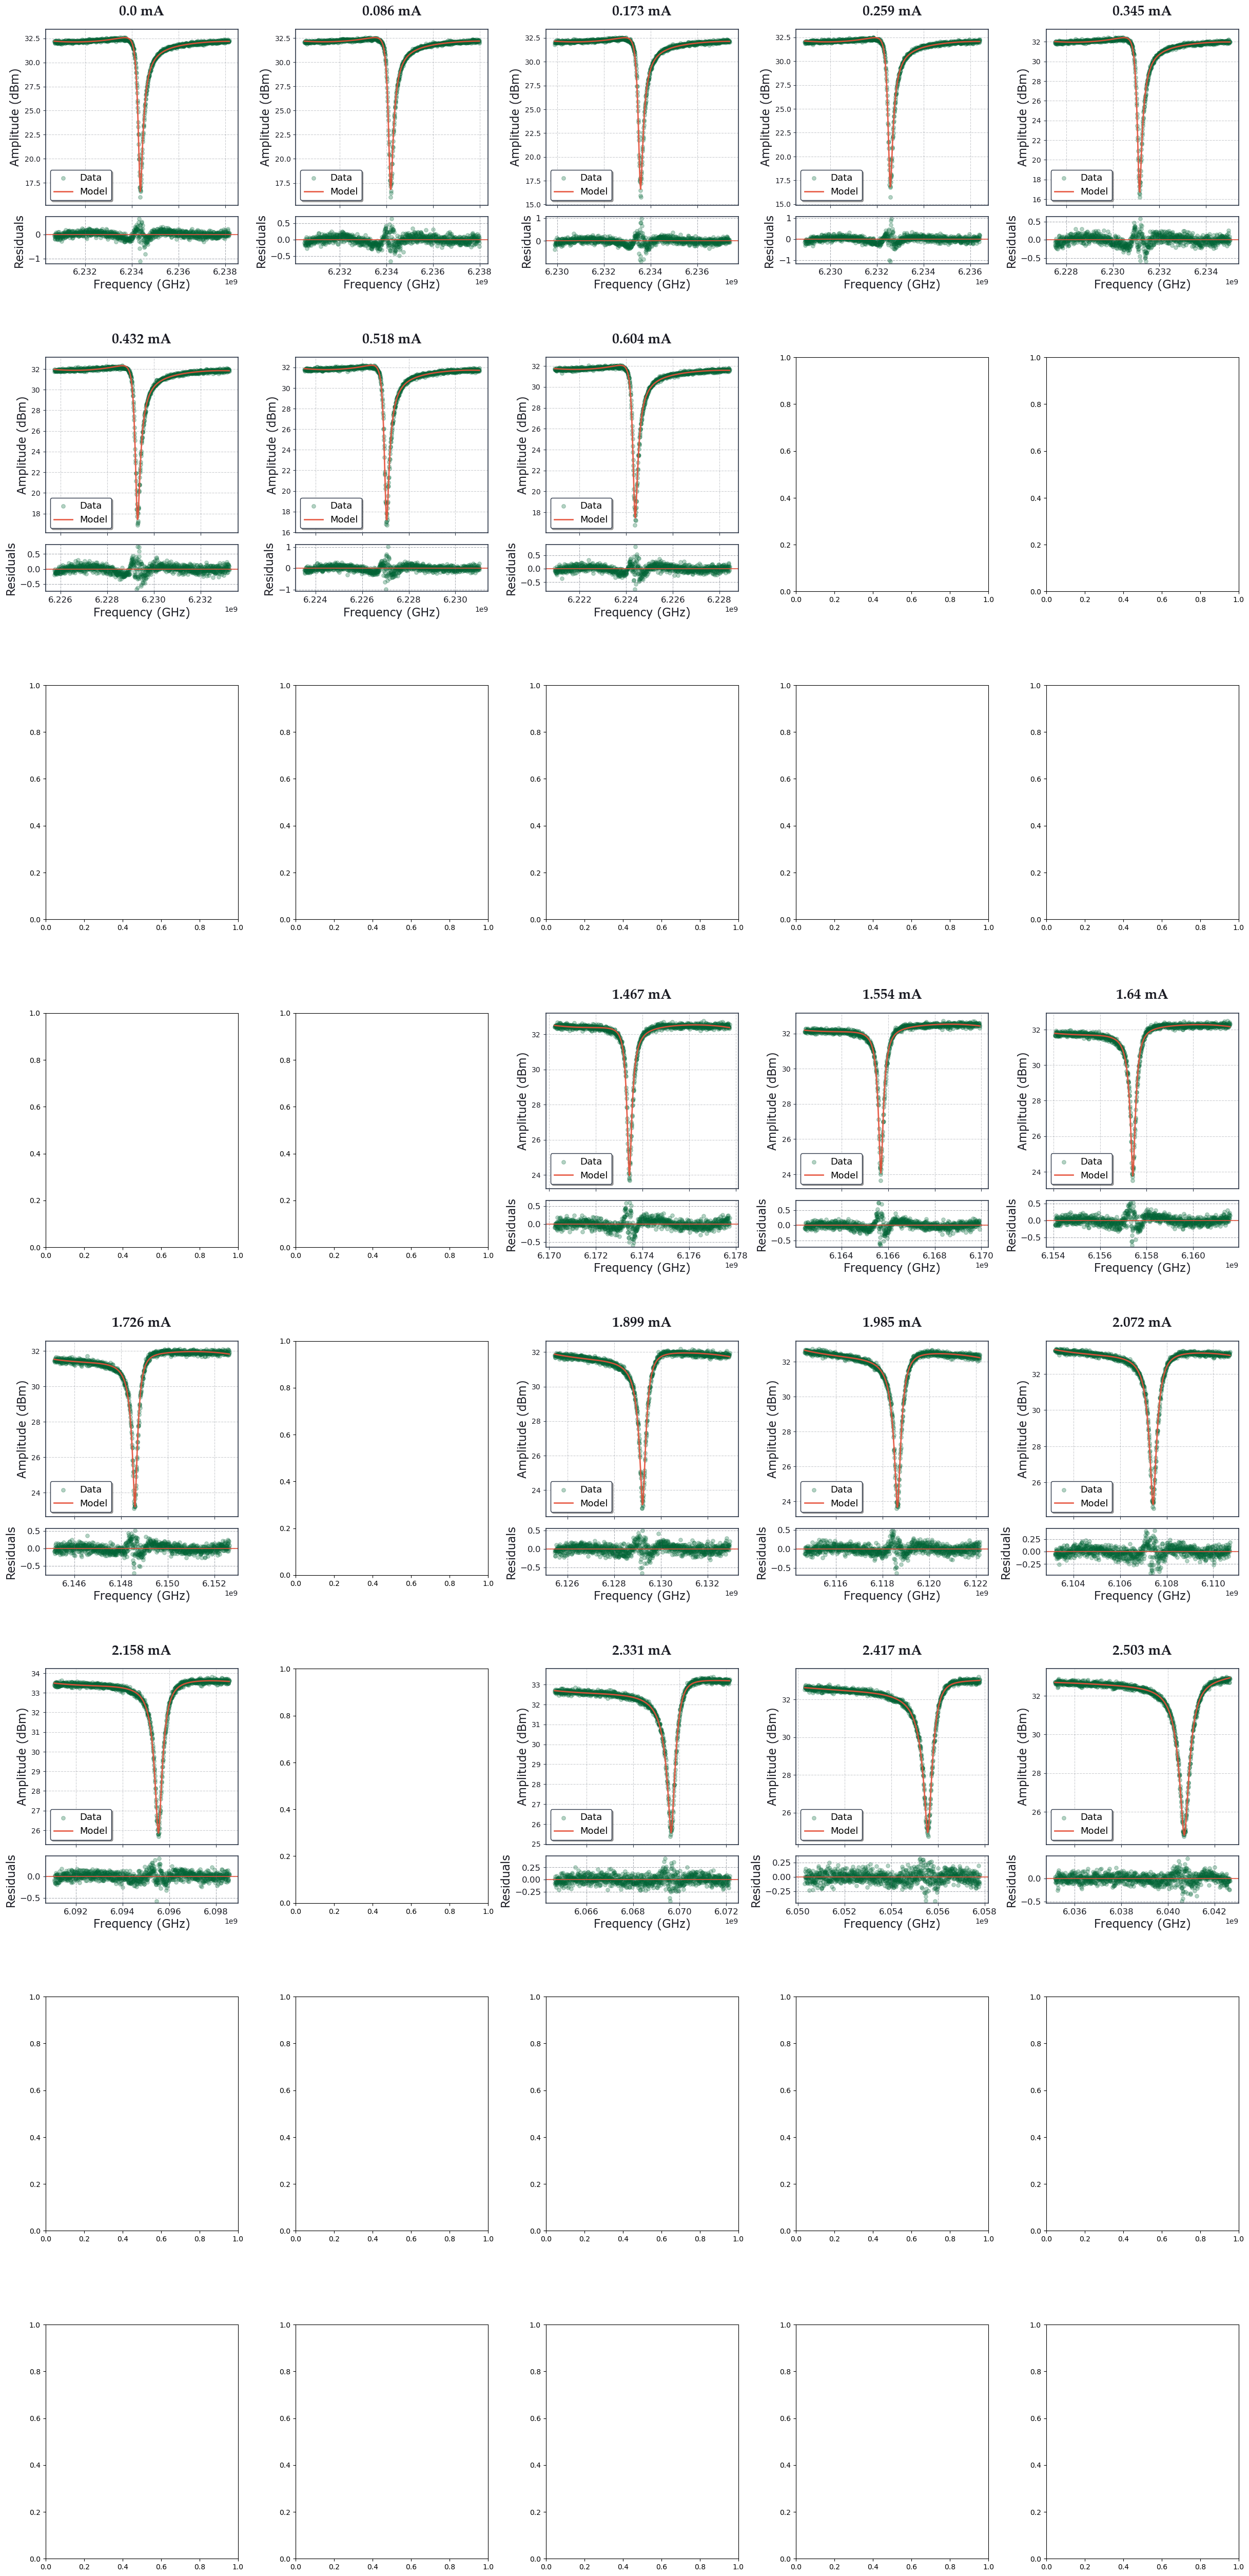

In [8]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-0/data/tr_sweep_data.h5')

resonance_frequneces_1 = []
bias_currents_1 = []
Qt_1 = []
Qc_1 = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks - changed to 5 columns
nrows = (nof_peaks + 4) // 5  # Calculate required rows for 5 columns

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})

row_iter = 0
col_iter = 0
pippo = 0

initial_guess = {
    "f0": -50000, #17000, #0.1,
    "phi": 0.17, #-0.2369, # 2.1,
    "Qc": 14000, #29208,
    "A": 10.0, #1.0,
    "B": 1e-7, #2.8643e-8 ,#1e-9,
    "C": 1e-14, #8.0398e-15,#1e-18,
    "D": -7e-21, #-3.5988e-20, # 1e-27
    }

param_limits = {
    "Qc": (1e2, 1e7),
    "Qt": (1e2, 1e7),
    #'phi': (-20, 20),
    #'f0': (-1e6, 1e6),
    }

for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T

    f_i = f
    y_i = amp_dBm
    
    fmin = f[np.argmin(y_i)]
    initial_guess['fmin'] = fmin
    fwhm = peak_width(f_i, -y_i)
    
    mask = (f_i > fmin - 7 * fwhm) & (f_i < fmin + 7 * fwhm)
    f_i = f_i[mask]
    y_i = y_i[mask]

    # Estimate the initial guess of Qt
    Qt_guess = fmin / peak_width(f_i, -y_i)
    initial_guess['Qt'] = Qt_guess

    # Estimate the initial guess of K
    initial_guess['K'] = (np.max(y_i) - np.min(y_i)) * initial_guess['Qc'] / initial_guess['Qt']
    #print(f"Initial guess: {initial_guess}")
    
    # try to fit
    model = md.resonance_model
    
    fitter = Fitter_old(model_function=model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares,
                        params_initial_guess=initial_guess,
                        params_range=param_limits
                    )

    # searcher = ResonancePeakSearcher(version="T")
    # result = fitter.fit(searcher=searcher)

    fitter.model.set_fixed_params({"fmin": fmin})
    result = fitter.fit()

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value(result)
        if p_value < 0.01:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = fmin #searcher.params['fmin']
            resonance_frequneces_1.append(resonance_frequency)
            bias_currents_1.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + fmin #searcher.params['fmin']
            resonance_frequneces_1.append(resonance_frequency)
            bias_currents_1.append(bias_current)
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = fmin #searcher.params['fmin']
            plot_fit(peak_data, model, fitted_params,
                     title=f'{round(bias_current, 3)} mA', 
                     xlabel='Frequency (GHz)', 
                     ylabel='Amplitude (dBm)', 
                     palette=QSciencePalette, 
                     typography=QScienceTypography, 
                     ax=ax[row_iter, col_iter],
                     rasterize_points=True)
            
            Qt_1.append(fitted_params['Qt'])
            Qc_1.append(fitted_params['Qc'])

            print(fitted_params)

    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = fmin #searcher.params['fmin']
        resonance_frequneces_1.append(resonance_frequency)
        #bias_currents.append(bias_current)
        
    if pippo > 37:
        # delete ax
        fig.delaxes(ax[row_iter, col_iter])

    # update iterators - changed to 5 columns
    col_iter += 1
    pippo+=1
    if col_iter >= 5:  # Changed from 8 to 5 columns
        col_iter = 0
        row_iter += 1
    


plt.show()
